In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np
from PIL import Image
from tensorflow.keras.optimizers import Adam
import os
##from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense, Input
from tensorflow.keras.regularizers import l2
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.models import Model

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 128

In [3]:
def preprocess_image(image, label):
    image = tf.keras.applications.vgg19.preprocess_input(image)

    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

    return image, label

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls "/content/drive/My Drive/"

'Colab Notebooks'   Dataset1.zip   dataset3.zip   dataset.zip
 dataset_1.zip	    Dataset2.zip   dataset4.zip   fake_news_dataset.zip


In [6]:
import zipfile

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/drive/My Drive/Dataset1.zip'
extraction_path = '/content/Dataset'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [7]:
dataset_path = "/content/Dataset/Blood cell Cancer [ALL]"

In [8]:
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
).map(preprocess_image)
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
subset_size = int(1.0 * dataset_size)

# Take 20% of the dataset
dataset = full_dataset.take(subset_size)

Found 3242 files belonging to 4 classes.


In [9]:
class_names = sorted(os.listdir(dataset_path))

print(class_names)

['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']


In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 128, 128, 3)
[3 3 2 2 1 2 0 0 3 0 2 0 2 0 0 3]


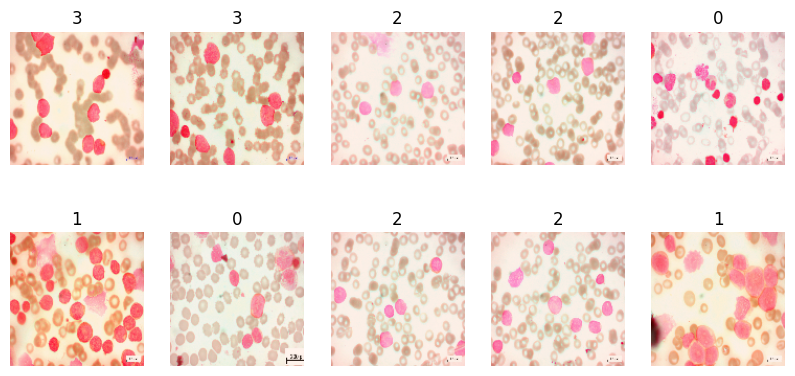

In [11]:
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))

    num_images = min(10, images.shape[0])

    for i in range(num_images):
        ax = plt.subplot(4, 5, i + 1)
        img = images[i].numpy()

        if img.min() < 0 or img.max() > 1:
            img = ((img - img.min()) / (img.max() - img.min()) * 255).astype("uint8")
        else:
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        plt.title(int(labels[i]))
        plt.axis("off")

    plt.show()
    break

In [12]:
len(dataset)

203

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

142

In [16]:
len(val_ds)

30

In [17]:
len(test_ds)

31

In [18]:
def custom_augmentation(image, label):

    # Random flip
    image = tf.image.random_flip_left_right(image)

    #Random brightness and contrast adjustment
    # image = tf.image.random_brightness(image, max_delta=0.1)
    # image = tf.image.random_contrast(image, lower=0.9, upper=1.0)

    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image, label

train_ds = train_ds.map(custom_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, multiply

# def se_block(input_tensor, reduction_ratio=8):
#     """ Squeeze-and-Excitation Block """
#     channels = input_tensor.shape[-1]  # Number of channels
#     se = GlobalAveragePooling2D()(input_tensor)  # Squeeze operation
#     se = Dense(channels // reduction_ratio, activation='relu')(se)  # Bottleneck layer
#     se = Dense(channels, activation='sigmoid')(se)  # Scale each channel
#     se = Reshape((1, 1, channels))(se)  # Reshape to broadcast
#     return multiply([input_tensor, se])  # Recalibrate the feature maps

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔷 Training VGG16...
Learning rate: 0.0001
Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 68s 231ms/step - accuracy: 0.3961 - loss: 3.7580 - val_accuracy: 0.7542 - val_loss: 1.3162 - learning_rate: 1.0000e-04
Learning rate: 8.187307530779819e-05
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.7035 - loss: 1.6600 - val_accuracy: 0.9146 - val_loss: 1.0110 - learning_rate: 8.1873e-05
Learning rate: 6.703200460356394e-05
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7907 - loss: 1.3132 - val_accuracy: 0.9312 - val_loss: 0.9321 - learning_rate: 6.7032e-05
Learning rate: 5.488116360940264e-05
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8281 - loss: 1.1832 - val_accuracy: 0.9354 - val_loss: 0.8912 - learning_rate: 5.4881e-05
Learning rate: 4.493289641172216e-05
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8644 - loss: 1.0475 - val_accuracy: 0.9417 - val_loss: 0.86

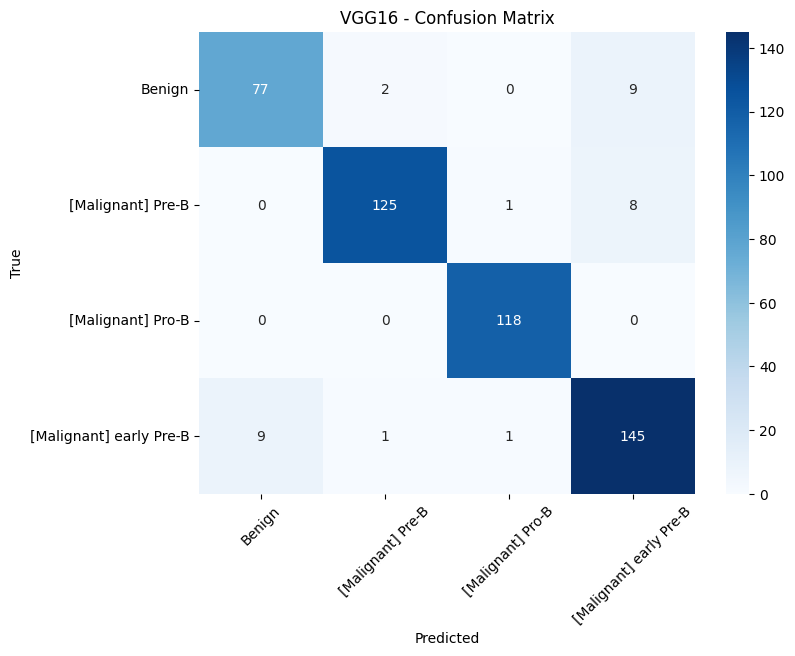


🔹 Classification Report for VGG16:

                         precision    recall  f1-score   support

                 Benign       0.90      0.88      0.89        88
      [Malignant] Pre-B       0.98      0.93      0.95       134
      [Malignant] Pro-B       0.98      1.00      0.99       118
[Malignant] early Pre-B       0.90      0.93      0.91       156

               accuracy                           0.94       496
              macro avg       0.94      0.93      0.94       496
           weighted avg       0.94      0.94      0.94       496



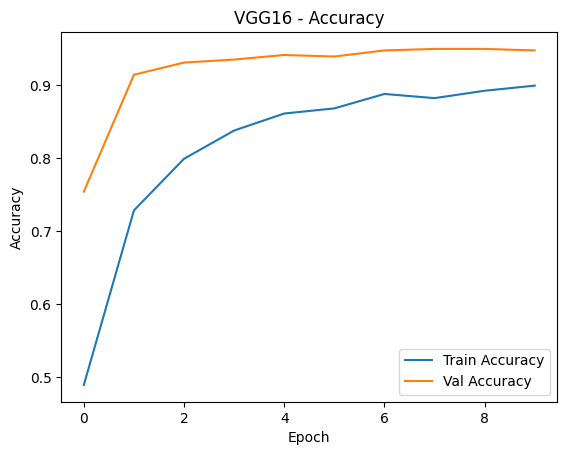

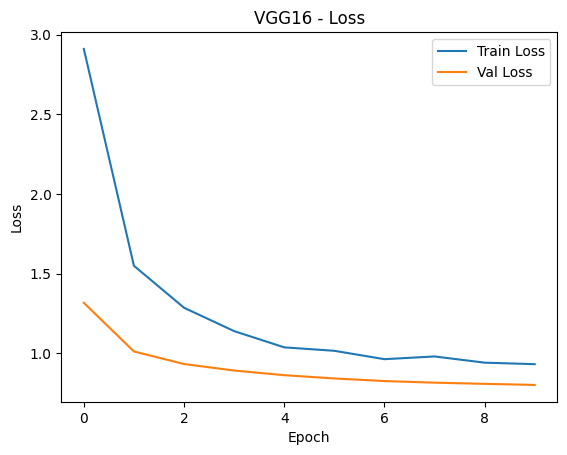

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔷 Training ResNet50...
Learning rate: 0.0001
Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.5179 - loss: 2.3572 - val_accuracy: 0.9167 - val_loss: 1.2156 - learning_rate: 1.0000e-04
Learning rate: 8.187307530779819e-05
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8741 - loss: 1.2893 - val_accuracy: 0.9500 - val_loss: 1.0238 - learning_rate: 8.1873e-05
Learning rate: 6.703200460356394e-05
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9354 - loss: 1.0932 - val_accuracy: 0.9688 - val_loss: 0.9325 - learning_rate: 6.7032e-05
Learning rate: 5.488116360940264e-05
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9438 - loss: 0.9853 - val_accuracy: 0.9625 - val_loss: 0.8852 - learning_rate: 5.4881e-05
Learning rate: 4.493289641172216e-05
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9567 - loss: 0.9203 - val_accuracy: 0.9750 - val_loss: 0.84

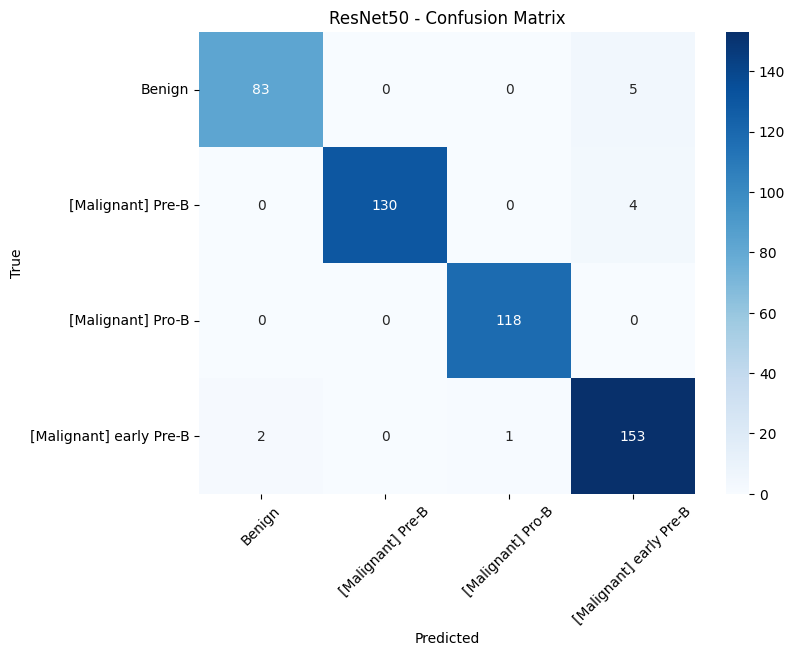


🔹 Classification Report for ResNet50:

                         precision    recall  f1-score   support

                 Benign       0.98      0.94      0.96        88
      [Malignant] Pre-B       1.00      0.97      0.98       134
      [Malignant] Pro-B       0.99      1.00      1.00       118
[Malignant] early Pre-B       0.94      0.98      0.96       156

               accuracy                           0.98       496
              macro avg       0.98      0.97      0.98       496
           weighted avg       0.98      0.98      0.98       496



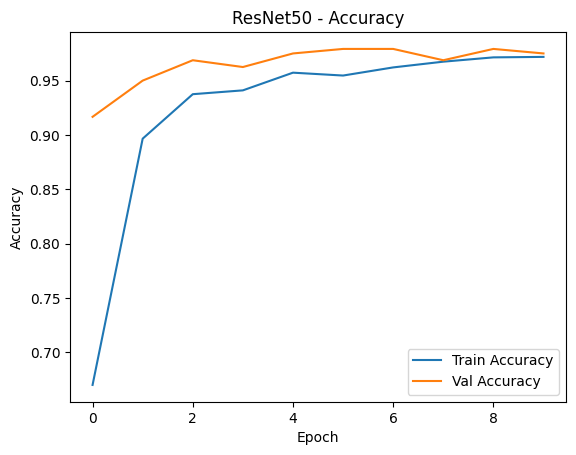

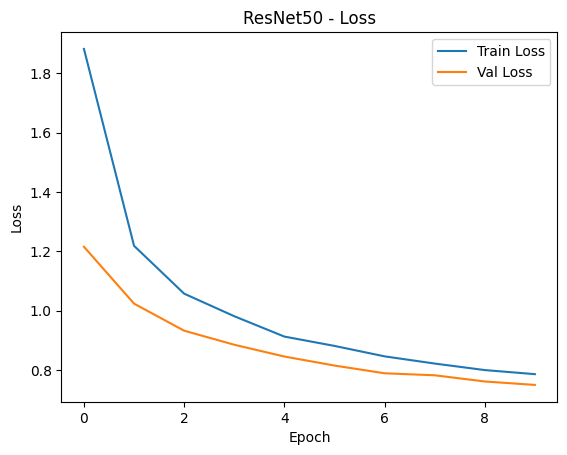

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔷 Training EfficientNetB0...
Learning rate: 0.0001
Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.5790 - loss: 2.1142 - val_accuracy: 0.9354 - val_loss: 1.2781 - learning_rate: 1.0000e-04
Learning rate: 8.187307530779819e-05
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8863 - loss: 1.3582 - val_accuracy: 0.9604 - val_loss: 1.0890 - learning_rate: 8.1873e-05
Learning rate: 6.703200460356394e-05
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9327 - loss: 1.1650 - val_accuracy: 0.9688 - val_loss: 1.0138 - learning_rate: 6.7032e-05
Learning rate: 5.488116360940264e-05
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9320 - loss: 1.1011 - val_accuracy: 0.9583 - val_loss: 0.9845 - learning_rate: 5.4881e-05
Learning rate: 4.493289641172216e-05
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9385 - loss: 1.0538 - val_accuracy: 0.9667 - val_loss

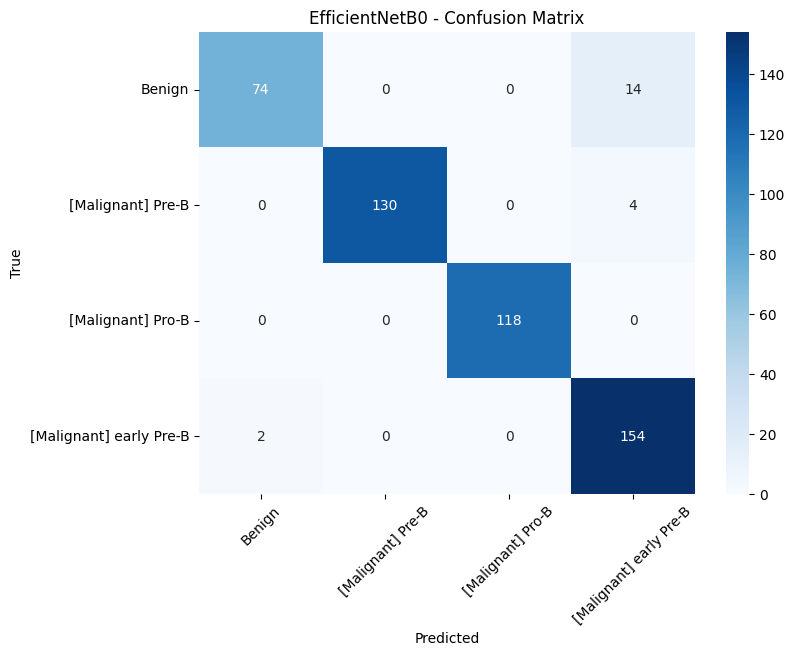


🔹 Classification Report for EfficientNetB0:

                         precision    recall  f1-score   support

                 Benign       0.97      0.84      0.90        88
      [Malignant] Pre-B       1.00      0.97      0.98       134
      [Malignant] Pro-B       1.00      1.00      1.00       118
[Malignant] early Pre-B       0.90      0.99      0.94       156

               accuracy                           0.96       496
              macro avg       0.97      0.95      0.96       496
           weighted avg       0.96      0.96      0.96       496



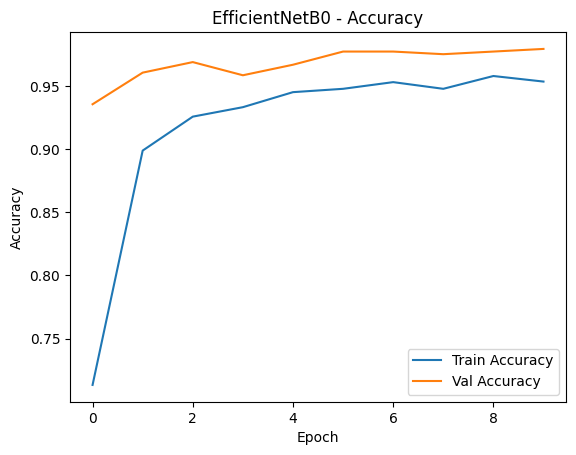

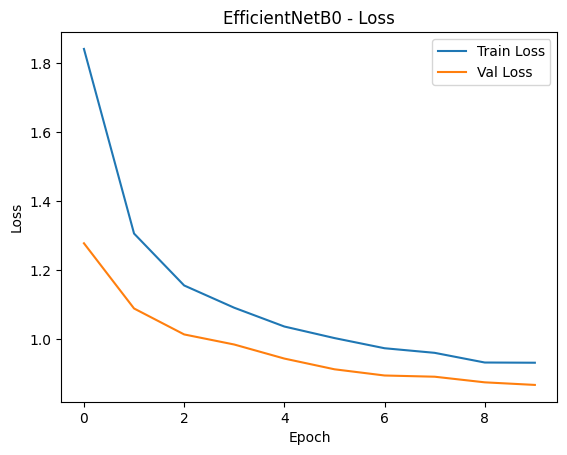

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔷 Training MobileNetV2...
Learning rate: 0.0001
Epoch 1/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.4751 - loss: 2.1978 - val_accuracy: 0.8208 - val_loss: 1.4112 - learning_rate: 1.0000e-04
Learning rate: 8.187307530779819e-05
Epoch 2/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7491 - loss: 1.4592 - val_accuracy: 0.8333 - val_loss: 1.2038 - learning_rate: 8.1873e-05
Learning rate: 6.703200460356394e-05
Epoch 3/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8054 - loss: 1.2717 - val_accuracy: 0.8604 - val_loss: 1.0855 - learning_rate: 6.7032e-05
Learning rate: 5.488116360940264e-05
Epoch 4/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8338 - loss: 1.1217 - val_accuracy: 0.8667 - val_loss: 1.0194 - learning_rate: 5.4881e-05
Learning rate: 4.493289641172216e-05
Epoch 5/10
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8437 - loss: 1.0617 - val_accuracy: 0.8687 - val_loss: 0.9

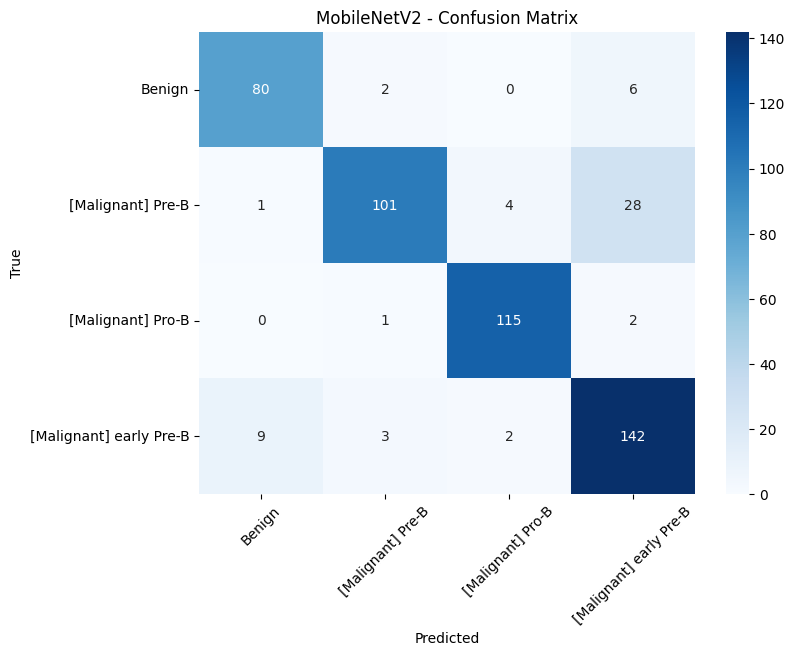


🔹 Classification Report for MobileNetV2:

                         precision    recall  f1-score   support

                 Benign       0.89      0.91      0.90        88
      [Malignant] Pre-B       0.94      0.75      0.84       134
      [Malignant] Pro-B       0.95      0.97      0.96       118
[Malignant] early Pre-B       0.80      0.91      0.85       156

               accuracy                           0.88       496
              macro avg       0.90      0.89      0.89       496
           weighted avg       0.89      0.88      0.88       496



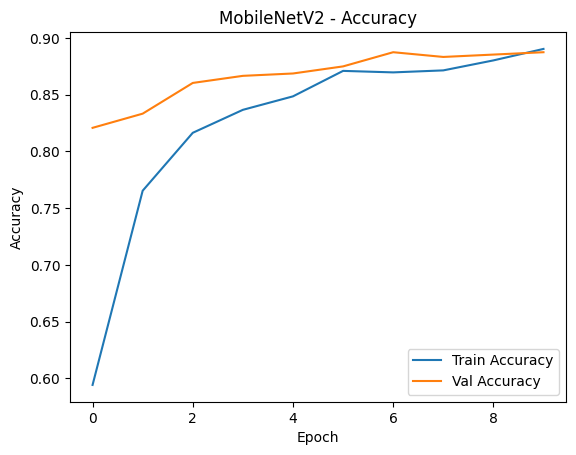

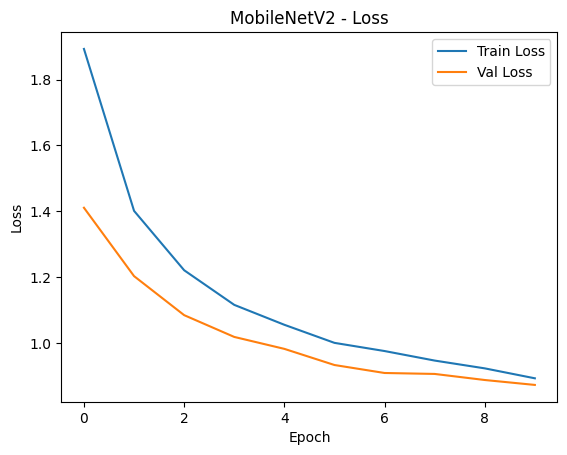

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report

# Set input and number of classes
input_shape = (128, 128, 3)
num_classes = 4


# Learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 1e-4
    k = 0.2
    lr = initial_lr * np.exp(-k * epoch)
    print("Learning rate:", lr)
    return lr

# Create model using transfer learning
def create_model(base_model_fn, model_name):
    base_model = base_model_fn(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze base model

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name=model_name)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate model
def train_and_evaluate(model, name):
    print(f"\n🔷 Training {name}...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        batch_size=BATCH_SIZE,
        callbacks=[LearningRateScheduler(lr_schedule)],
        verbose=1
    )

    loss, accuracy = model.evaluate(test_ds)
    print(f"🔹 {name} Test loss:", loss)
    print(f"🔹 {name} Test accuracy:", accuracy)

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    true_labels = []
    for _, labels in test_ds.unbatch():
        true_labels.append(labels.numpy())
    true_labels = np.array(true_labels)

    class_names = ['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

    cm = confusion_matrix(true_labels, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap="Blues", annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.show()

    print(f"\n🔹 Classification Report for {name}:\n")
    print(classification_report(true_labels, predicted_classes, target_names=class_names))

    # Accuracy & Loss Curves
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# === Run for all base models ===
models = {
    'VGG16': VGG16,
    'ResNet50': ResNet50,
    'EfficientNetB0': EfficientNetB0,
    'MobileNetV2': MobileNetV2
}

for name, base_fn in models.items():
    model = create_model(base_fn, name)
    train_and_evaluate(model, name)

